## Exploratory Data Analysis

Working on: https://www.kaggle.com/c/understanding_cloud_organization/

In [2]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split

from src.utils import create_mask_for_image

Our goal is to segment satellite images of the ocean according to the cloud formations present in the image.

Below are examples of each of the flour classes of clouds:

![https://joshvarty.files.wordpress.com/2019/09/clouds.png?w=1100](https://joshvarty.files.wordpress.com/2019/09/clouds.png?w=1100)

Our goal is to output multiple masks (one for each class) for a given image. Visualized, this would look something like:

![https://joshvarty.files.wordpress.com/2019/09/clouds2-1.png](https://joshvarty.files.wordpress.com/2019/09/clouds2-1.png)

In [3]:
DATA = 'data'
train = pd.read_csv("data/train.csv")

In [4]:
train.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


`EncodedPixels` uses [Run-length Encoding](https://en.wikipedia.org/wiki/Run-length_encoding) to represent the image masks without storing a value for every single pixel.

In [6]:
train.shape

(22184, 2)

In [7]:
train_path = f'{DATA}/train_images/'
mask_path = f'{DATA}/train_images_annots/'
test_path = f'{DATA}/test_images/'
n_train = len(os.listdir(train_path))
n_test = len(os.listdir(test_path))
print(f'There are {n_train} images in train dataset')
print(f'There are {n_test} images in test dataset')

There are 5546 images in train dataset
There are 3698 images in test dataset


Let's take a look at how many instances of each class we have:

In [8]:
train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[1]).value_counts()

Sugar     3751
Gravel    2939
Fish      2781
Flower    2365
Name: Image_Label, dtype: int64

So our class balance ranges from ~19% for Flower to ~31% for Sugar. 

Let's take a look at **the count** of classes are present in each image:

In [9]:
train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().value_counts()

2    2372
3    1560
1    1348
4     266
Name: Image_Label, dtype: int64

This means we have:
- 1,348 images with one class
- 2,373 images with two classes
- 1,560 images with three classes
- 266 images with four classes

Let's separate out the filename and the label for each image.

In [8]:
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
train.head()

,Image_Label,EncodedPixels,label,im_id
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,Fish,0011165.jpg
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,Flower,0011165.jpg
2,0011165.jpg_Gravel,NaN,Gravel,0011165.jpg
3,0011165.jpg_Sugar,NaN,Sugar,0011165.jpg
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,Fish,002be4f.jpg


In [9]:
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

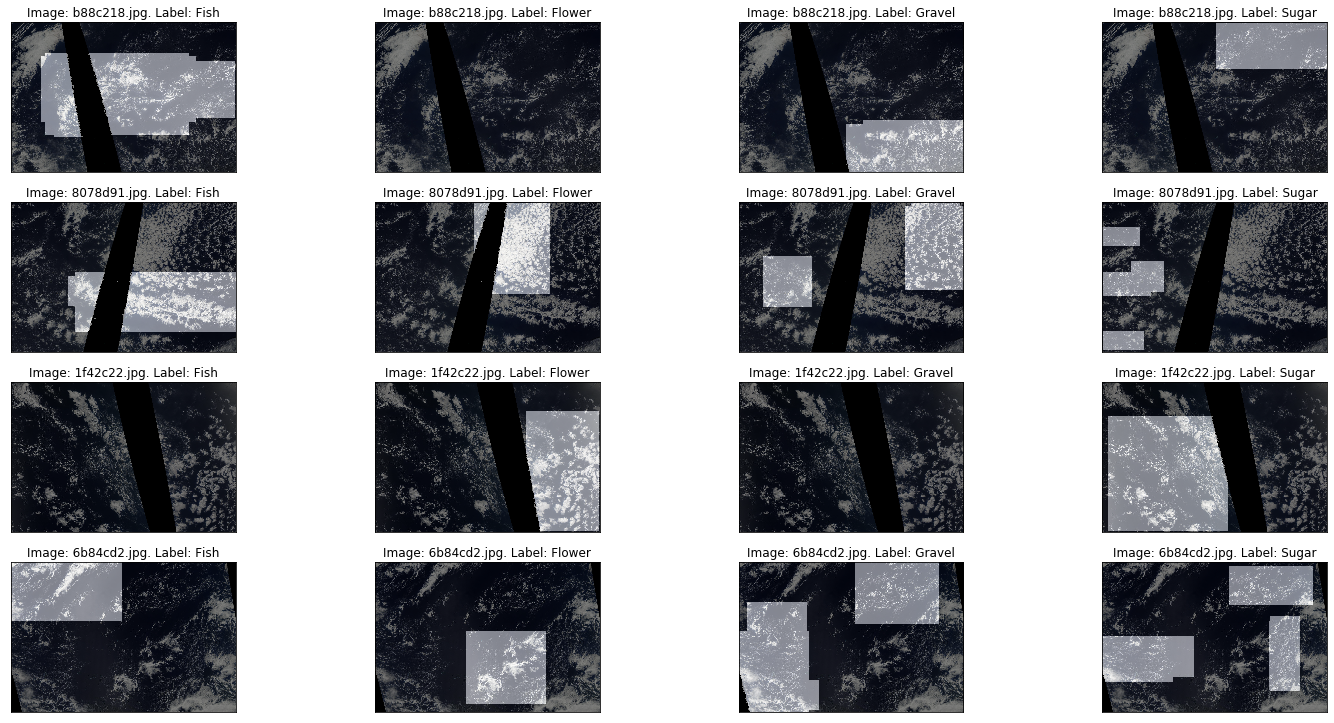

In [10]:
fig = plt.figure(figsize=(25, 16))
for j, im_id in enumerate(np.random.choice(train['im_id'].unique(), 4)):
    for i, (idx, row) in enumerate(train.loc[train['im_id'] == im_id].iterrows()):
        ax = fig.add_subplot(5, 4, j * 4 + i + 1, xticks=[], yticks=[])
        im = Image.open(f"{DATA}/train_images/{row['Image_Label'].split('_')[0]}")
        plt.imshow(im)
        mask_rle = row['EncodedPixels']
        if isinstance(mask_rle, str):
            mask = rle_decode(mask_rle)
        else:
            mask = np.zeros((1400, 2100))
        plt.imshow(mask, alpha=0.5, cmap='gray')
        ax.set_title(f"Image: {row['Image_Label'].split('_')[0]}. Label: {row['label']}")

In [11]:
id_mask_count = train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().\
reset_index().rename(columns={'index': 'img_id', 'Image_Label': 'count'})
train_ids, valid_ids = train_test_split(id_mask_count['img_id'].values, random_state=42, stratify=id_mask_count['count'], test_size=0.1)

## Convert Run Length Encoding to Image Masks

In [12]:
train.head()

,Image_Label,EncodedPixels,label,im_id
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,Fish,0011165.jpg
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,Flower,0011165.jpg
2,0011165.jpg_Gravel,NaN,Gravel,0011165.jpg
3,0011165.jpg_Sugar,NaN,Sugar,0011165.jpg
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,Fish,002be4f.jpg


FastAI wants complete image masks for training so let's create them.

In [18]:
for row in train.iloc[::4, :].iterrows():
    index = row[0]
    
    newImage = create_mask_for_image(train, index)
    
    if not os.path.exists("data/train_images_annots"):
        os.mkdir("data/train_images_annots")
        
    im = Image.fromarray(newImage, mode='RGBA')
    im.save("data/train_images_annots/" + fish['im_id'].replace('.jpg', '.png'))

## Resize Images and Masks

During training, we appear to be bottlenecked by loading the full-size `1400x2100` images and resizing them so they're small enough to fit on the GPU.

To avoid doing this repeatedly during training, let's create multiple smaller sized datasets.

If we're brave, we could try progressive resizing which Jeremy says works well.

In [32]:
original_size = (1400, 2100)
new_size = (350, 525)
height, width = new_size

In [39]:
def resizeImagesInDirectory(oldPath, newPath, height, width, fileType="JPEG"):
    
    old_images = os.listdir(oldPath)

    #Make sure the folder exists
    if not os.path.exists(newPath):
        os.mkdir(newPath)
    
    #Go through directory, resize and save in newPath
    for image in old_images:
        fullPath = oldPath + image
        newFullPath = newPath + image
        
        #If the file already exists, don't waste time opening/resizing/saving it
        if os.path.exists(newFullPath):
            continue

        img = Image.open(fullPath)
        
        if fileType == "JPEG":
            newSize = (width, height)
            img.thumbnail(newSize, Image.ANTIALIAS)
            img.save(newFullPath, fileType)
        else:
            # We don't seem to be able to use thumbnail to rescale our custom RGBA masks
            # I think that it may be removing the RGB portions of the image whenever
            # opacity is 0 (ie. for almost everything)
            a = np.asarray(img)
            if a.ndim== 2: 
                a = np.expand_dims(a,2)
            a = np.transpose(a, (1, 0, 2))
            a = np.transpose(a, (2, 1, 0))
            
            # large image is shape (4, 1400, 2100)
            # small image is shape (4, 350, 525)
            input_size = np.array((1400, 2100))
            output_size = np.array((height, width))
            bin_size = input_size // output_size
            
            newImage = a.reshape((4, output_size[0], bin_size[0], output_size[1], bin_size[1])).max(4).max(2)
            newImage = np.transpose(newImage, (1,2,0))
            
            
            
            #Convert back to image and save
            im = Image.fromarray(newImage, mode='RGBA')
            
            im.save(newFullPath)            
            

In [36]:
train_masks = os.listdir(mask_path)
test_images = os.listdir(test_path)

new_train_path = f'{DATA}/train_images_{new_size[0]}x{new_size[1]}/'
new_mask_path = f'{DATA}/train_images_annots_{new_size[0]}x{new_size[1]}/'
new_test_path = f'{DATA}/test_images_{new_size[0]}x{new_size[1]}/'

In [37]:
new_mask_path

'data/train_images_annots_350x525/'

In [38]:
resizeImagesInDirectory(train_path, new_train_path, height=height, width=width)

In [ ]:
resizeImagesInDirectory(test_path, new_test_path, height=height, width=width)

In [112]:
resizeImagesInDirectory(mask_path, new_mask_path, new_size, "PNG")